In [3]:
DATA_ROOT = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face"

**Data reduction**

We want the indices to be divisible by 8 so that they fit the model correctly.

In [7]:
# ----- global grid definition -----
H, W = 495, 436  # rows, cols

min_lon, max_lon = 13.189, 13.625   # west, east
min_lat, max_lat = 52.359, 52.854   # south, north

# cell size (assuming regular grid)
lon_step = (max_lon - min_lon) / W
lat_step = (max_lat - min_lat) / H

# ----- sub-grid indices ----- 

r0, r1 = 10, 274   # row range [128, 200)
c0, c1 = 0, 432 # col range [128, 200)

# Multiples of 8
m8 = lambda x: (x+7)//8*8
r0,r1,c0,c1 = map(m8, (r0,r1,c0,c1))


R_H = r1 - r0
R_W = c1 - c0

# If row 0 = south edge (increasing row → increasing latitude):
sub_min_lat = min_lat + r0 * lat_step
sub_max_lat = min_lat + r1 * lat_step
sub_min_lon = min_lon + c0 * lon_step
sub_max_lon = min_lon + c1 * lon_step


In [8]:
import folium



# ----- center of the subarea -----
center_lat = (sub_min_lat + sub_max_lat) / 2
center_lon = (sub_min_lon + sub_max_lon) / 2

# ----- create folium map -----
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# rectangle showing the reduced grid area
folium.Rectangle(
    bounds=[
        [sub_min_lat, sub_min_lon],  # SW corner
        [sub_max_lat, sub_max_lon],  # NE corner
    ],
    fill=False,
    color="red",
    weight=2,
).add_to(m)

# optionally also draw the full grid extent for reference
folium.Rectangle(
    bounds=[
        [min_lat, min_lon],
        [max_lat, max_lon],
    ],
    fill=False,
    color="blue",
    weight=1,
).add_to(m)

#m


In [ ]:
import os
import json

# save them as metadata
rows = r1 - r0
cols = c1 - c0

# If row 0 = south edge (increasing row → increasing latitude):
sub_min_lat = min_lat + r0 * lat_step
sub_max_lat = min_lat + r1 * lat_step
sub_min_lon = min_lon + c0 * lon_step
sub_max_lon = min_lon + c1 * lon_step

metadata = {
    "rows": rows,
    "cols": cols,
    "bbox": [
        [sub_min_lat, sub_min_lon],   # southwest corner
        [sub_max_lat, sub_max_lon]    # northeast corner
    ]
}

meta_path = os.path.join(DATA_ROOT, "BERLIN_reduced", "metadata.json")

#with open(meta_path, "w", encoding="utf-8") as f:
    #json.dump(metadata, f, indent=2)

**Experiment reduced**

We want to don´t have to much detail becouse without the proper machinary it becomes noise so we reduce the experiment. We want the proyect to emphasizes structural patterns, that is where land-use data can be more usefull.

We are going to work only with the center of berlin: 
(we after make it modulus 8 so that it maches the GPU restrictions)
- the times between 100 -220 (peak hours).
For the time we are going to perform for 15 min a sum over time of the volumes  and a mean over time of the speed, since we care about big patrons of movement in the city and low scale would be to ambitious for the hardware we have.

Since we are going to perform a lot of experiments we preprocess the data to have that shape.

**moves reducing**
1. hours range
2. space
3. time agregation

**Check that the reducing worked well**

In [1]:
import h5py, glob, os
DATA_ROOT = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face"
out_dir = os.path.join(DATA_ROOT, "BERLIN_reduced", "data")
paths   = sorted(glob.glob(os.path.join(out_dir, "*_8ch.h5")))

shapes = {}
for p in paths:
    with h5py.File(p, "r") as f:
        arr = f["array"]
        shapes[p] = arr.shape

# Fast consistency check
unique_shapes = set(shapes.values())

print("Number of files:", len(paths))
print("Unique shapes found:", unique_shapes)

if len(unique_shapes) == 1:
    print("All files have the same shape:", unique_shapes.pop())
else:
    print("Inconsistent shapes detected:")
    for k, v in shapes.items():
        print(k, v)


Number of files: 180
Unique shapes found: {(120, 264, 432, 8)}
All files have the same shape: (120, 264, 432, 8)


**Mask reducing**

In [11]:
import os, h5py, numpy as np

mask_path = os.path.join(DATA_ROOT, "BERLIN", "BERLIN", "BERLIN_static.h5")
out_path  = os.path.join(DATA_ROOT, "BERLIN_reduced", "BERLIN_static.h5")

with h5py.File(mask_path, "r") as f:
    static = f["array"][()]   # (C, H, W)

static_crop = static[:, r0:r1, c0:c1]   # (C, H_roi, W_roi)

#with h5py.File(out_path, "w") as f:
#    f.create_dataset("array", data=static_crop, compression="gzip")

#print("Saved:", out_path, "shape:", static_crop.shape)


**Visualization on the webpage experiment**

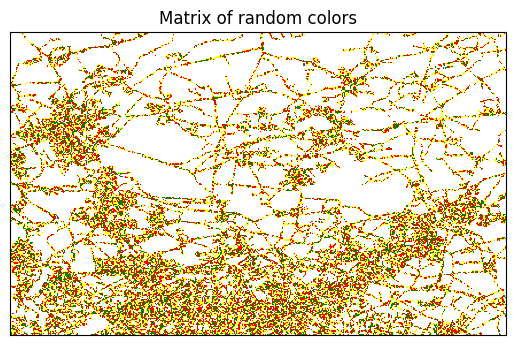

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Parameters
H_r = rows   # number of rows
W_r = cols   # number of columns

# Define allowed colors
colors = ["white", "yellow", "red", "green"]

# Create random matrix with color indices
matrix = np.random.randint(0, len(colors), size=(H_r, W_r))

matrix[static_crop[0] == 0] = 0

# Create a custom color map
cmap = mcolors.ListedColormap(colors)

# Visualization
plt.imshow(matrix, cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.title("Matrix of random colors")
plt.show()


### Extracting the geojson LBCS geogrid and the LBCS first level tensor

This process was to heavy to be hold in a jupyter notebook and it is done in the python file build_grid_geojson.py.

However we can visualize the result here:

In [ ]:
import json
import folium
import numpy as np
from grid_maker.build_final_geojson import extract_code   # << reuse existing logic

# color map (your original palette)
LBCS_COLOR_MAP = {
    "1000": "#FFFF00",  # yellow
    "2000": "#FF0000",  # red
    "3000": "#A020F0",  # purple
    "4000": "#BEBEBE",  # gray
    "5000": "#90EE90",  # light green
    "6000": "#0000FF",  # blue
    "7000": "#008B8B",  # dark cyan
    "8000": "#551A8B",  # purple4
    "9000": "#228B22",   # forest green
    "0000": "#FFFFFF"   # White
}

# load enriched grid
grid_path = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face\BERLIN_reduced\\grid_first_level.geojson"
with open(grid_path, "r") as f:
    grid = json.load(f)


# Compute map center from first polygon to avoid scanning everything
first_coords = grid["features"][0]["geometry"]["coordinates"][0]
lats = [pt[1] for pt in first_coords]
lons = [pt[0] for pt in first_coords]
center = (sum(lats) / len(lats), sum(lons) / len(lons))

m = folium.Map(location=center, zoom_start=12)

for feat in grid["features"]:
    code = feat["properties"].get("lbcs_first_level", "0000")
    color = LBCS_COLOR_MAP.get(code, "#ffffff")

    folium.GeoJson(
        feat,
        style_function=lambda f, col=color: {
            "fillColor": col,
            "color": "#00000000",
            "weight": 0.3,
            "fillOpacity": 0.7,
        }
    ).add_to(m)

m

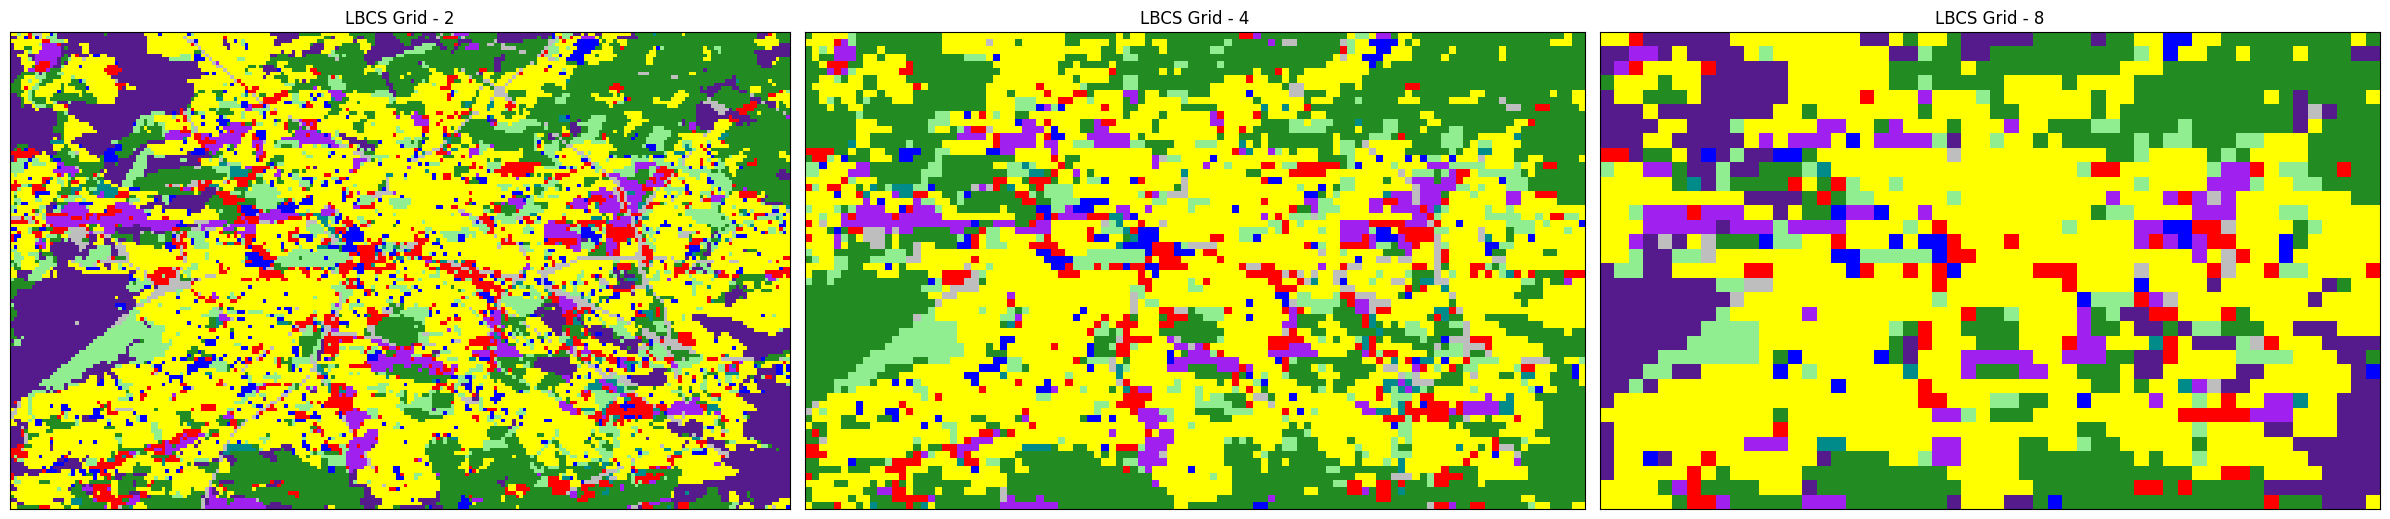

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# -------- paths --------
base_dir = os.path.join(DATA_ROOT, "BERLIN_reduced")

# -------- color map --------
LBCS_COLOR_MAP = {
    "1000": "#FFFF00",
    "2000": "#FF0000",
    "3000": "#A020F0",
    "4000": "#BEBEBE",
    "5000": "#90EE90",
    "6000": "#0000FF",
    "7000": "#008B8B",
    "8000": "#551A8B",
    "9000": "#228B22",
    "0000": "#FFFFFF"
}

def load_matrix(json_path):
    with open(json_path, "r") as f:
        matrix = json.load(f)
    return np.array(matrix)

def matrix_to_rgba(M):
    rows, cols = M.shape
    rgba_grid = np.zeros((rows, cols, 4))
    for i in range(rows):
        for j in range(cols):
            hex_color = LBCS_COLOR_MAP.get(M[i, j], "#FFFFFF")
            rgba_grid[i, j] = to_rgba(hex_color)
    return rgba_grid

# -------- discover all granularities --------
granularities = []
for name in os.listdir(base_dir):
    if name.startswith("grid_lbcs-"):
        level = name.split("-")[1]  # e.g. "4", "8", "16", etc.
        folder = os.path.join(base_dir, name)
        json_path = os.path.join(folder, "lbcs_matrix.json")
        if os.path.exists(json_path):
            granularities.append((level, json_path))

# sort levels numerically
granularities.sort(key=lambda x: int(x[0]))

# load matrices and convert
matrices = []
for level, path in granularities:
    M = load_matrix(path)
    rgba = matrix_to_rgba(M)
    matrices.append((level, rgba))

# -------- plot dynamically --------
n = len(matrices)
fig, axes = plt.subplots(1, n, figsize=(8*n, 8))

if n == 1:
    axes = [axes]  # keep iterable

for ax, (level, rgba) in zip(axes, matrices):
    ax.imshow(rgba)
    ax.set_title(f"LBCS Grid - {level}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Not enought detail - all becomes residential :

- 1000 Residence or accommodation functions
- 2000 General sales or services
- 3000 Manufacturing and wholesale trade
- 4000 Transportation, communication, information, and utilities
- 5000 Arts, entertainment, and recreation
- 6000 Education, public administration, health care, and other institutions
- 7000 Construction-related businesses
- 8000 Mining and extraction establishments
- 9000 Agriculture, forestry, fishing, and hunting

**Visualization tests of cell size of grid LBCS**

We want a grid that can be agregated to generate the bigger grid.

In [24]:
import math

def ith_common_divisor(h, w, i):
    d = math.gcd(h, w)
    divisors = [x for x in range(1, d+1) if d % x == 0]
    if i < 1 or i > len(divisors):
        raise ValueError("i is out of range")
    return divisors[i-1], h // divisors[i-1], w // divisors[i-1]


i = 5   # choose the 3rd common divisor
divisor, H_div, W_div = ith_common_divisor(H_r, W_r, i)

print("i-divisor:", divisor)
print("h/divisor:", H_div)
print("w/divisor:", W_div)


i-divisor: 6
h/divisor: 44
w/divisor: 72


In [25]:
import json
import numpy as np
import folium

# -------------------------------------------------------------------
# INPUTS
# -------------------------------------------------------------------
min_lon, max_lon = sub_min_lon, sub_max_lon
min_lat, max_lat = sub_min_lat, sub_max_lat 

H, W = H_div, W_div  # grid size

LBCS_COLOR_MAP = {
    "1000": "#c00000",
    "2000": "#00a933",
    "3000": "#0070c0",
    "4000": "#ffc000",
    "5000": "#7030a0",
    "6000": "#00b0f0",
    "7000": "#002060",
    "8000": "#a6a6a6",
    "9000": "#000000",
    "0000": "#ffffff",
}
classes = list(LBCS_COLOR_MAP.keys())

# -------------------------------------------------------------------
# CREATE RANDOM GRID OF CLASS CODES
# -------------------------------------------------------------------
grid = np.random.choice(classes, size=(H, W))

# cell size
dlat = (max_lat - min_lat) / H
dlon = (max_lon - min_lon) / W

# -------------------------------------------------------------------
# BUILD GEOJSON
# -------------------------------------------------------------------
features = []

for i in range(H):
    for j in range(W):
        lat1 = min_lat + i * dlat
        lat2 = min_lat + (i + 1) * dlat
        lon1 = min_lon + j * dlon
        lon2 = min_lon + (j + 1) * dlon

        class_id = grid[i, j]
        color = LBCS_COLOR_MAP[class_id]

        poly = {
            "type": "Feature",
            "properties": {
                "class": class_id,
                "color": color
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [[
                    [lon1, lat1],
                    [lon2, lat1],
                    [lon2, lat2],
                    [lon1, lat2],
                    [lon1, lat1]
                ]]
            }
        }
        features.append(poly)

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# optionally save:
with open("grid.geojson", "w") as f:
    json.dump(geojson_data, f)

# -------------------------------------------------------------------
# VISUALIZE WITH FOLIUM
# -------------------------------------------------------------------
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        "fillColor": feature["properties"]["color"],
        "color": None,
        "weight": 0,
        "fillOpacity": 0.5,
    }
).add_to(m)

m


This make sense also for using it as the LBCS-feature

**Process logic justification**

**Generate the Geojson grid**

We don´t need as much granularity for the land-use grid because it will became noise.

We are working in 100 m x 100 m cell sizes. We want to reduce the amount of cells but without lossing to much detail - 300 m make sense.


In [8]:
grid_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'id': 0},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.189, 52.633),
      (13.192, 52.633),
      (13.192, 52.63),
      (13.189, 52.63),
      (13.189, 52.633)),)}},
  {'type': 'Feature',
   'properties': {'id': 1},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.192, 52.633),
      (13.195, 52.633),
      (13.195, 52.63),
      (13.192, 52.63),
      (13.192, 52.633)),)}},
  {'type': 'Feature',
   'properties': {'id': 2},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.195, 52.633),
      (13.198, 52.633),
      (13.198, 52.63),
      (13.195, 52.63),
      (13.195, 52.633)),)}},
  {'type': 'Feature',
   'properties': {'id': 3},
   'geometry': {'type': 'Polygon',
    'coordinates': (((13.198, 52.633),
      (13.201, 52.633),
      (13.201, 52.63),
      (13.198, 52.63),
      (13.198, 52.633)),)}},
  {'type': 'Feature',
   'properties': {'id': 4},
   'geometry': {

In [9]:
import folium, numpy as np

# calcular centro
coords = [(lat, lon) for f in grid_geojson["features"] 
                    for lon, lat in f["geometry"]["coordinates"][0]]
center = (np.mean([c[0] for c in coords]), np.mean([c[1] for c in coords]))

# crear mapa
m = folium.Map(location=center, zoom_start=13)

# añadir grid
folium.GeoJson(
    grid_geojson,
    style_function=lambda f: {"color": "blue", "weight": 1, "fillOpacity": 0}
).add_to(m)

# m


**Compute its LBCS tags**

In the original version of the code, since it was made for the first sketch of an online aplication, the OSM data was collected from the overpass api, but here we want data from 2019 and also from a really big grid. So we need a modified version.

In [3]:
import os
import urllib.request
from grid_maker.build_final_geojson import extract_code

def download_berlin_pbf(data_root: str) -> str:
    url = "https://download.geofabrik.de/europe/germany/berlin-latest.osm.pbf"
    local_path = os.path.join(data_root, "berlin-latest.osm.pbf")

    if os.path.exists(local_path):
        print("[Info] Berlin .pbf already exists:", local_path)
        return local_path

    print("[Info] Downloading:", url)
    urllib.request.urlretrieve(url, local_path)
    print("[Info] Downloaded to:", local_path)
    return local_path

berlin_pbf_path = download_berlin_pbf(DATA_ROOT)


[Info] Downloading: https://download.geofabrik.de/europe/germany/berlin-latest.osm.pbf
[Info] Downloaded to: C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face\berlin-latest.osm.pbf


In [15]:
grid_code_coverage_tfidf = run_lbcs_pipeline(grid_geojson)
grid_code_coverage_tfidf

[Info] Using local Berlin .pbf with bbox: [13.189, 52.369, 13.621, 52.633]


: 

In [ ]:
import json
import os

out_path = os.path.join(DATA_ROOT, "BERLIN_reduced", "lbcs_tfidf.json")

with open(out_path, "w", encoding="utf-8") as f:
    json.dump(grid_code_coverage_tfidf, f, ensure_ascii=False, indent=2)

print("Saved to:", out_path)


In [ ]:
# VISUALIZATION
LBCS_COLOR_MAP = {
    "1000": "#c00000",
    "2000": "#00a933",
    "3000": "#0070c0",
    "4000": "#ffc000",
    "5000": "#7030a0",
    "6000": "#00b0f0",
    "7000": "#002060",
    "8000": "#a6a6a6",
    "9000": "#000000",
    "0000": "#ffffff",   # background / no data
}


**Create the tensor for the models**

In [ ]:
def lbcs_tensor_from_coverage(grid_code_coverage_tfidf, rows, cols, lbcs_depth=1):
    """
    grid_code_coverage_tfidf: {cell_id: {lbcs_code: weight}}
    Returns: tensor of shape (9, rows, cols) with one-hot encoding
             over the 9 functional LBCS dimensions (1xxx ... 9xxx).
    """
    tensor = np.zeros((9, rows, cols), dtype=np.float32)

    for cell_id, codes in grid_code_coverage_tfidf.items():
        if not codes:
            continue  # no data -> leave zeros

        # Best LBCS code using your existing logic
        code = extract_code(codes, level=lbcs_depth)  # e.g. "3100", "6100", "0000"

        if not code or code[0] == "0":
            continue  # unknown / background -> all zeros

        dim_index = int(code[0]) - 1  # "1" -> 0, ..., "9" -> 8

        row = cell_id // cols
        col = cell_id % cols
        if 0 <= row < rows and 0 <= col < cols:
            tensor[dim_index, row, col] = 1.0

    return tensor


**Generate the tensor array of LBCS**

## **train,test val split**

**How to do it?**

Since the webpage is going to have a python backend we don´t need to precompute all the tensors that we are going to pass to the model in the app.

**Unit of split = whole days (whole H5 files)**

For forecasting, we want to mimic reality:

- Train on past days.

- Validate on “future” days.

- Test on even later days.

We don´t want to have two copies of the data, so we keep a splits.json file with the partitions ranges.

**Shuffle**

- In **train**: We should shuffle the training set, because training with standard gradient descent depends on random gradient sampling.

- In **val** and **test**: No,  validation and test is meant to measure how well the model generalizes on unseen, chronologically later days.